«Модель прогнозирования стоимости жилья для агентства недвижимости»

Дипломный проект

Data Science

Описание данных:

'status' — статус продажи; 'private pool' и 'PrivatePool' — наличие собственного бассейна; 'propertyType' — тип объекта недвижимости; 'street' — адрес объекта; 'baths' — количество ванных комнат; 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);

'fireplace' — наличие камина; 'city' — город; 'schools' — сведения о школах в районе; 'sqft' — площадь в футах; 'zipcode' — почтовый индекс; 'beds' — количество спален; 'state' — штат; 'stories' — количество этажей; 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);

target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [53]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objs as go
import scipy as sp
import scipy.optimize as spo
from scipy import stats
import statsmodels.api as sm
from itertools import chain
from scipy.stats import shapiro
from scipy.stats import anderson
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import category_encoders as ce

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [54]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='target', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [55]:
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

Анализ данных

In [56]:
df = pd.read_csv('data/cleaned1_data.csv')
display(df.head())
df.info()

,status,street,baths,city,schools,sqft,zipcode,state,target,pool_encoded,Year built,Parking,lotsize,Price/sqft,Type,Cooling_encoded,Heating_encoded,fireplace_encoded
0,Active,240 Heather Ln,4.0,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,NC,418000,False,'2019','',None,'$144',single_family_home,False,True,True
1,For Sale,12911 E Heroy Ave,3.0,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,99216,WA,310000,False,'2019','','5828 sqft','$159/sqft',single_family_home,False,False,False
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,90049,CA,2895000,True,'1961','Attached Garage',"'8,626 sqft'",'$965/sqft',single_family_home,True,True,True
3,For Sale,4311 Livingston Ave,8.0,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,75205,TX,2395000,False,'2006','Detached Garage',"'8,220 sqft'",'$371/sqft',single_family_home,True,True,True
4,For Sale,1524 Kiscoe St,0.0,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",0,32908,FL,5000,False,'','',"'10,019 sqft'",None,land,False,False,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374370 entries, 0 to 374369
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             374370 non-null  object 
 1   street             374370 non-null  object 
 2   baths              374370 non-null  float64
 3   city               374370 non-null  object 
 4   schools            374370 non-null  object 
 5   sqft               374370 non-null  int64  
 6   zipcode            374370 non-null  int64  
 7   state              374370 non-null  object 
 8   target             374370 non-null  int64  
 9   pool_encoded       374370 non-null  bool   
 10  Year built         374370 non-null  object 
 11  Parking            374370 non-null  object 
 12  lotsize            374370 non-null  object 
 13  Price/sqft         374370 non-null  object 
 14  Type               374370 non-null  object 
 15  Cooling_encoded    374370 non-null  bool   
 16  He

In [57]:
df['zipcode'] = df['zipcode'].astype(str)

In [58]:
# Список булевых признаков:
bin_features = ['pool_encoded','Heating_encoded','Cooling_encoded','fireplace_encoded']

# Список категориальных признаков:
cat_features = ['status', 'street', 'city', 'schools', 'zipcode','state','Type','Year built']
 
# Список числовых признаков:
num_features = ['baths', 'sqft', 'target']

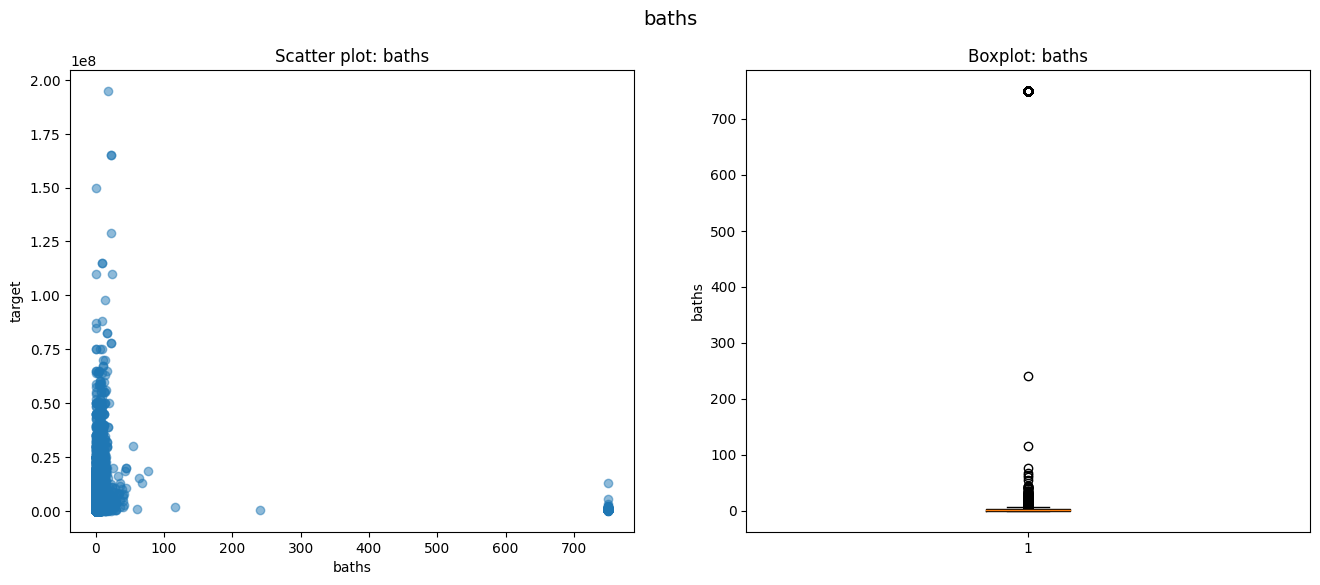

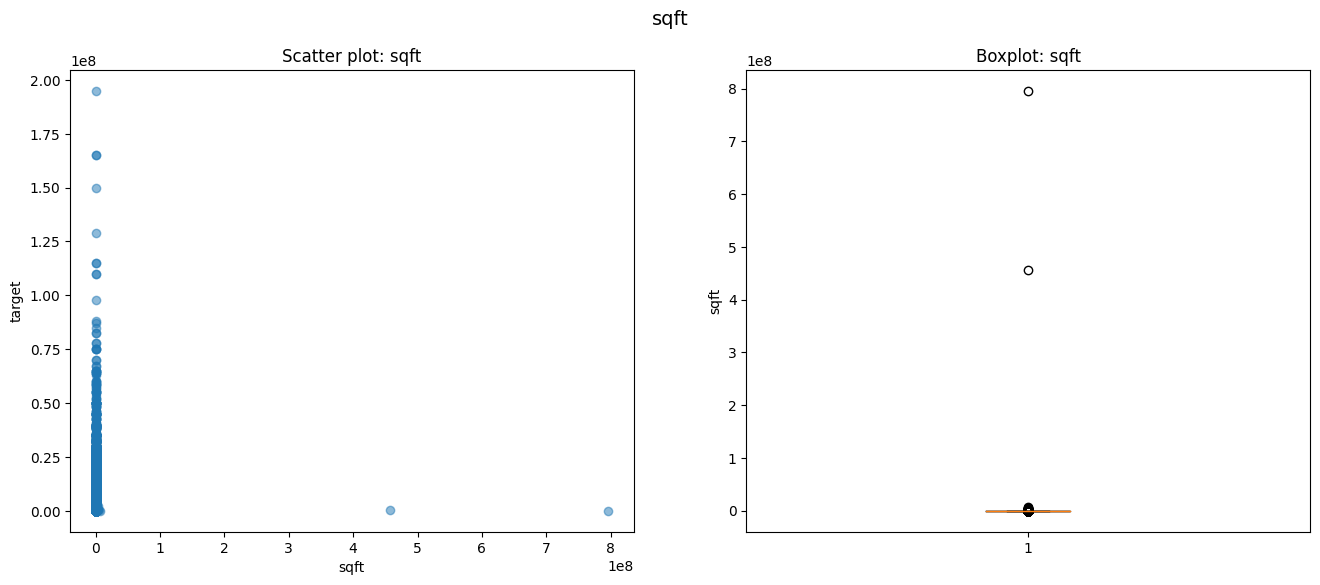

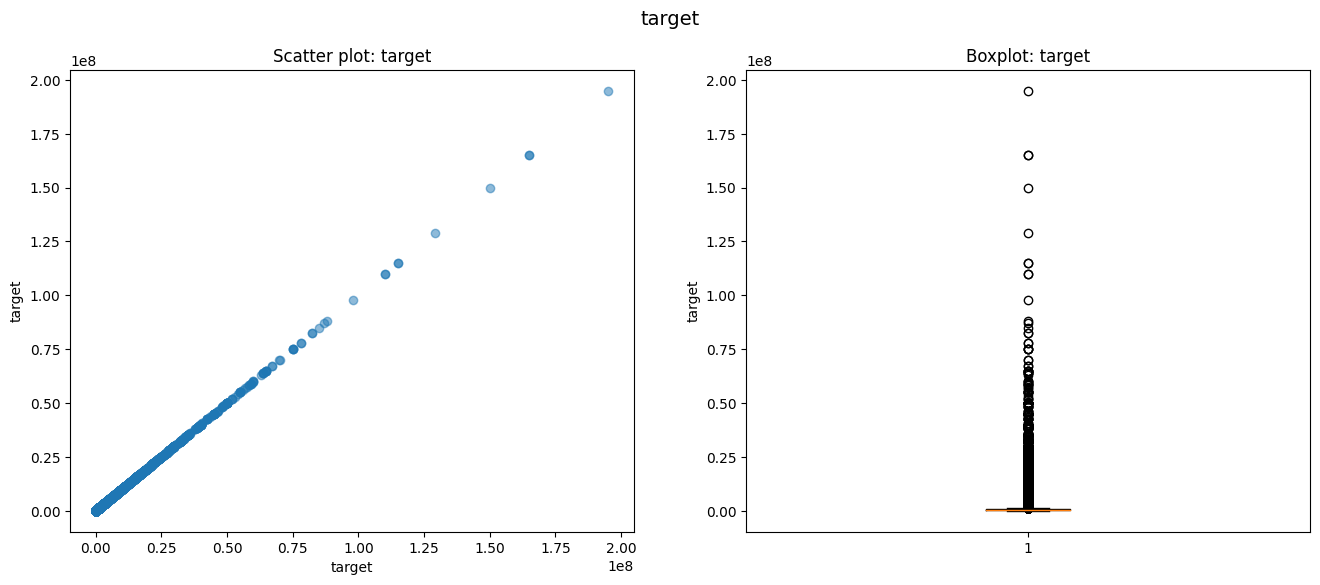

In [59]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

Интересуют bath 116, 241, 750, target 0, 195, sqft > 456

In [60]:

condition = (df['baths'].isin([116,241,750]))
filtered_df = df[condition]
display(filtered_df.head(5))
average_sqft = filtered_df['sqft'].mean()
print("Среднее значение sqft: ", average_sqft)

,status,street,baths,city,schools,sqft,zipcode,state,target,pool_encoded,Year built,Parking,lotsize,Price/sqft,Type,Cooling_encoded,Heating_encoded,fireplace_encoded
1095,Active,3624 Douglas Ave,750.0,Dallas,"[{'rating': ['5', '5', '2', '10'], 'data': {'D...",1758,75219,TX,499000,False,'1993','',"'2,200 Sq. Ft.'",'$284 / Sq. Ft.',other,True,False,True
1999,Active,920 I St NW #411,750.0,Washington,"[{'rating': ['8', '8', '3', '8'], 'data': {'Di...",1367,20001,DC,1499000,False,'2013','','—','$1097 / Sq. Ft.',other,False,False,False
3562,Active,601 W 11th Ave #409,750.0,Denver,"[{'rating': ['5', 'NR', '5', '2'], 'data': {'D...",873,80204,CO,348900,False,'1981','','—','$400 / Sq. Ft.',other,True,True,False
7496,Active,1260 Xavier St,750.0,Denver,"[{'rating': ['2', '2', '2'], 'data': {'Distanc...",1864,80204,CO,560000,False,'1936','','—','$300 / Sq. Ft.',other,False,True,False
7623,Active,3314 Douglas Ave Unit 202D,750.0,Dallas,"[{'rating': ['4', '3', '2', '10'], 'data': {'D...",1336,75219,TX,285000,False,'1984','','—','$213 / Sq. Ft.',condo,True,False,True


Среднее значение sqft:  2101.8870292887027


In [61]:
# Удаляем выбросы
df.drop(df[condition].index, inplace=True)

In [62]:
condition1 = ((df['sqft'] == 0) & (df['target'] == 195000000)) | (df['sqft'] > 455000000)
filtered1_df = df[condition1]
display(filtered1_df)

,status,street,baths,city,schools,sqft,zipcode,state,target,pool_encoded,Year built,Parking,lotsize,Price/sqft,Type,Cooling_encoded,Heating_encoded,fireplace_encoded
62316,For Sale,1723 Pulte St,2.0,Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '2/10', '...",795979430,45225,OH,27500,False,'1901',"'Attached Garage, Carport'",'2874 sqft','$0/sqft',single_family_home,True,True,True
131491,For Sale,875 Nimes Rd,18.0,Los Angeles,"[{'rating': ['10/10', '7/10'], 'data': {'Dista...",0,90077,CA,195000000,True,'1935','40 spaces','6.49 acres','No Data',single_family_home,True,True,True
373718,Active,5382 S Dixie Hwy,0.0,Glendale,"[{'rating': ['5', '7', '7', 'NR', 'NR', 'NR'],...",456602479,42740,KY,198000,False,'2012','','456509','No Info',multi_family_home,True,True,False


In [63]:
# Удаляем выбросы
df.drop(df[condition1].index, inplace=True)

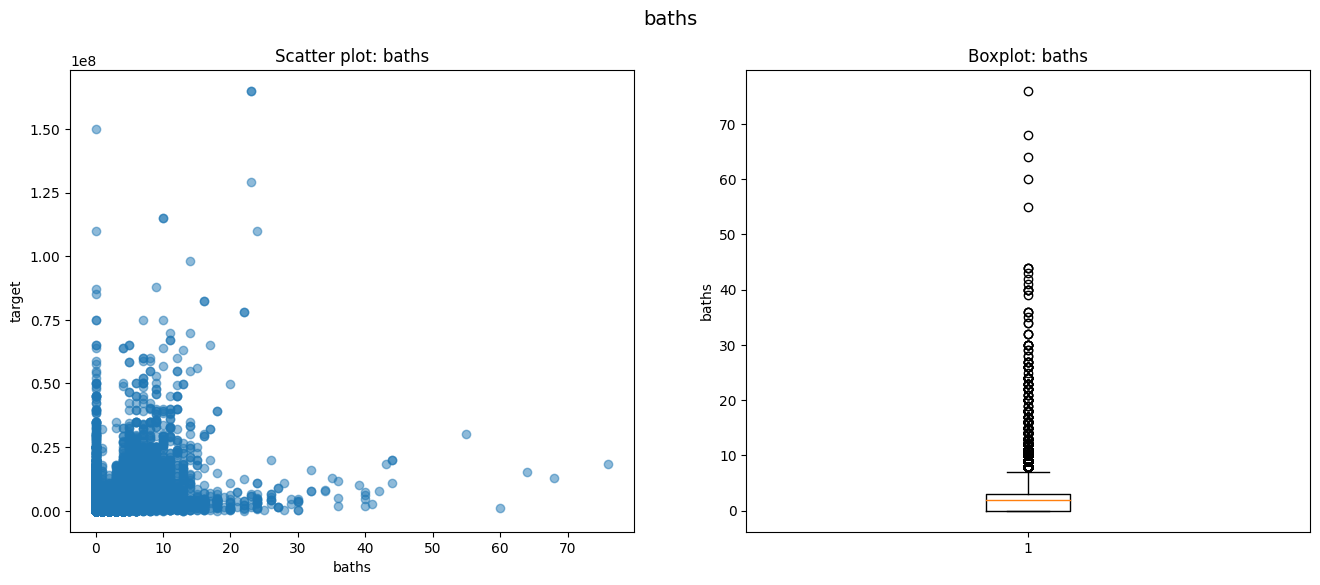

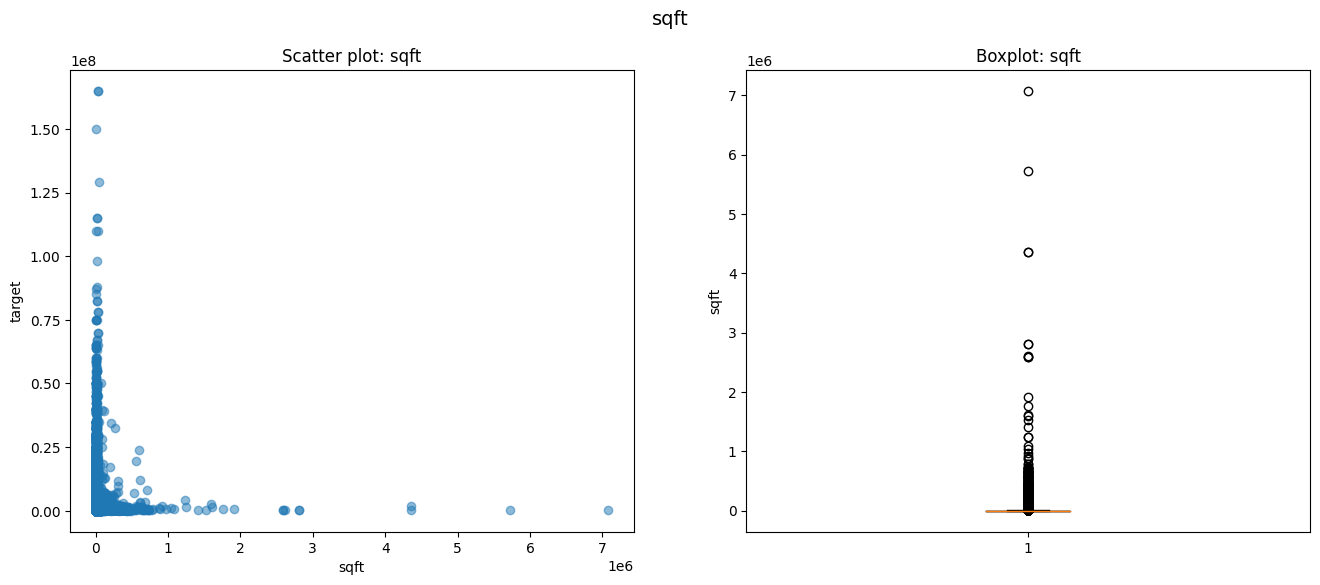

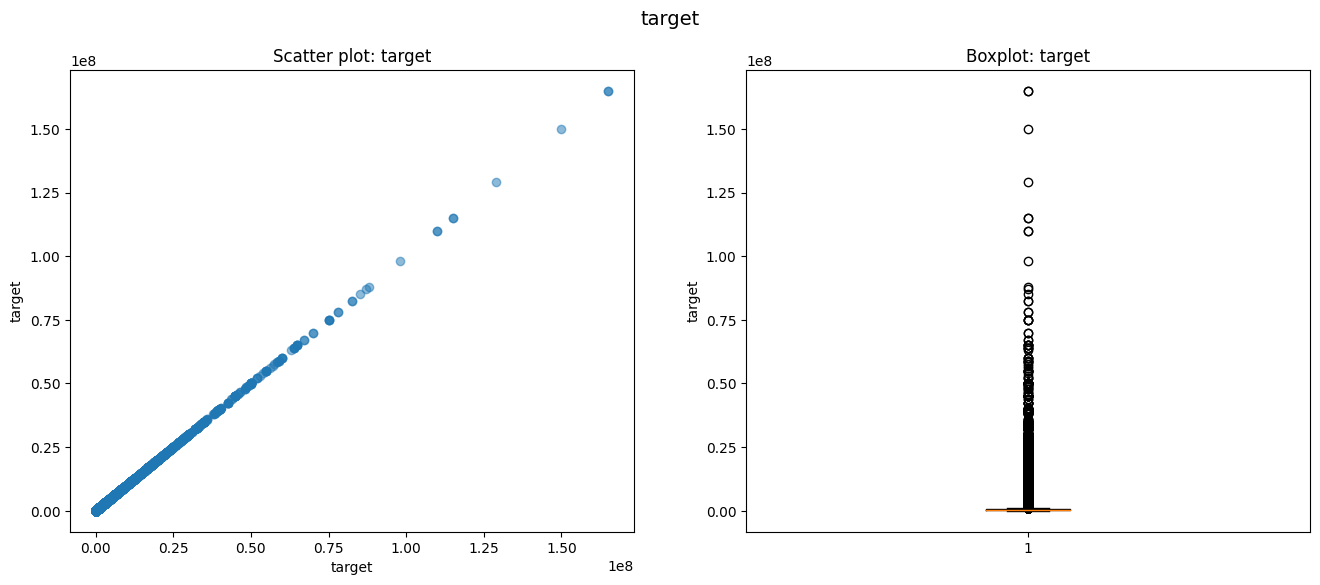

In [64]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

Удаление оставшихся выбросов

In [65]:
condition3 = ((df['baths'] > 30) | (df['target'] > 750000)) | (df['sqft'] > 200000)
filtered3_df = df[condition3]
print(len(filtered3_df))
display(filtered3_df.head(5))

65981


,status,street,baths,city,schools,sqft,zipcode,state,target,pool_encoded,Year built,Parking,lotsize,Price/sqft,Type,Cooling_encoded,Heating_encoded,fireplace_encoded
2,For Sale,2005 Westridge Rd,2.0,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,90049,CA,2895000,True,'1961','Attached Garage',"'8,626 sqft'",'$965/sqft',single_family_home,True,True,True
3,For Sale,4311 Livingston Ave,8.0,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,75205,TX,2395000,False,'2006','Detached Garage',"'8,220 sqft'",'$371/sqft',single_family_home,True,True,True
15,For Sale,930 52nd St,0.0,Brooklyn,"[{'rating': ['8', '8', '3'], 'data': {'Distanc...",0,11219,NY,1650000,False,'1905','',"'2,003 Sq. Ft.'",None,single_family_home,True,False,False
17,Active,24 W 126th St,0.0,New York,"[{'rating': ['2', '5', '1', '2'], 'data': {'Di...",3325,10027,NY,2650000,False,'1899','',"'1,782 Sq. Ft.'",'$797 / Sq. Ft.',townhouse,False,False,False
21,For Sale,61425 Gosney Rd,5.0,Bend,"[{'rating': ['8/10', '5/10', '6/10'], 'data': ...",5266,97702,OR,3500000,False,'2008','4 spaces','15.32 acres lot','$665',single_family_home,True,True,True


In [66]:
# Удаляем выбросы
df.drop(df[condition3].index, inplace=True)

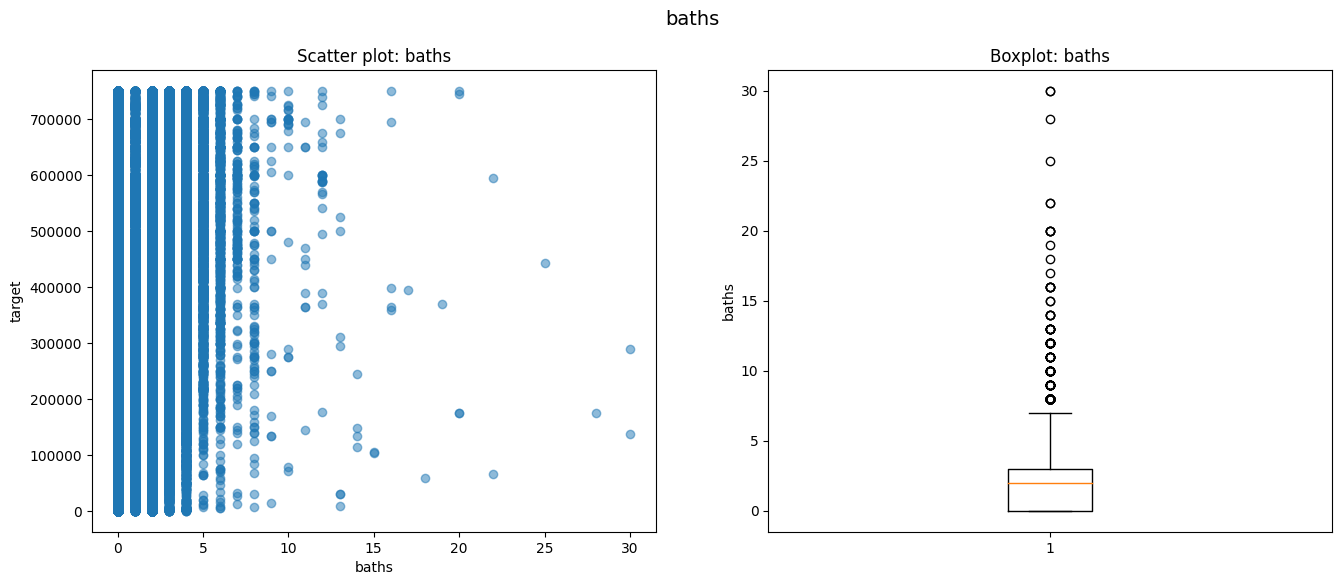

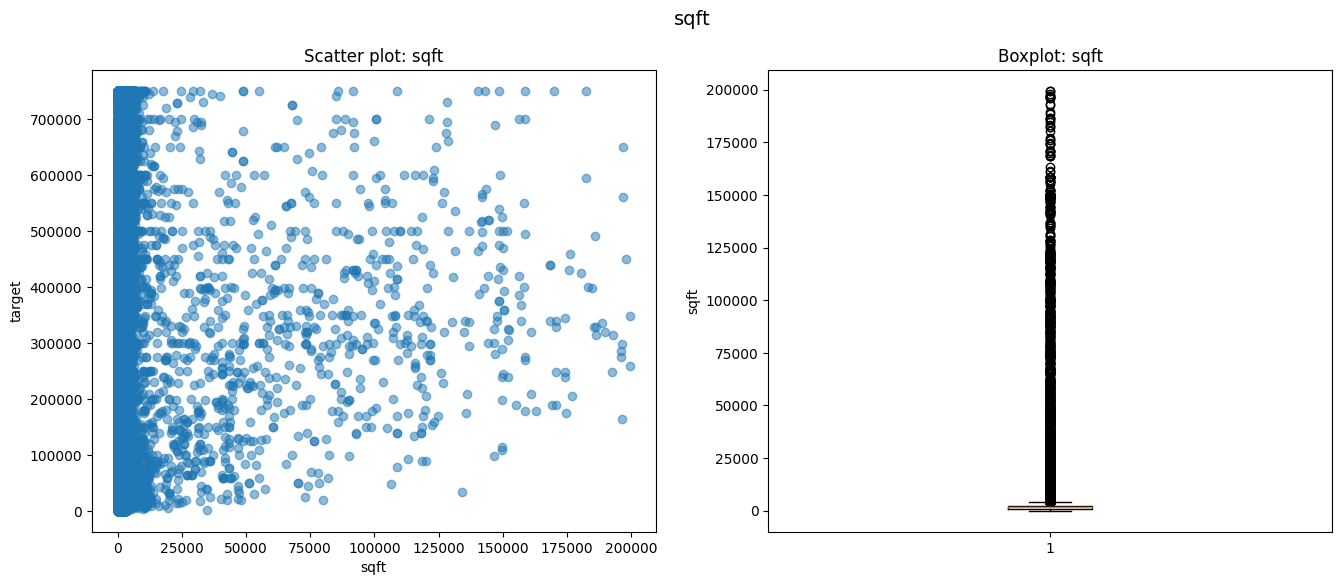

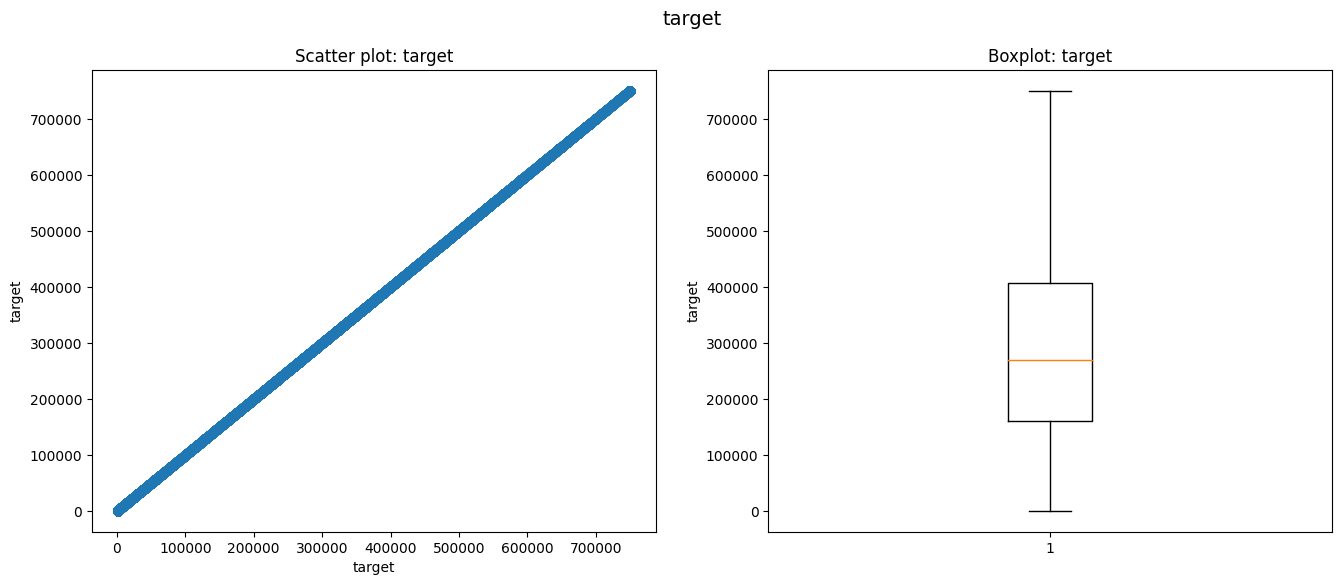

In [67]:
# Создание графика рассеивания и ящика с усами для каждого признака
for feature in num_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{feature}', fontsize=14)

    # График рассеивания
    ax1.scatter(df[feature], df['target'], alpha=0.5)
    ax1.set_title(f'Scatter plot: {feature}')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('target')

    # Ящик с усами
    ax2.boxplot(df[feature])
    ax2.set_title(f'Boxplot: {feature}')
    ax2.set_ylabel(feature)

    plt.show()

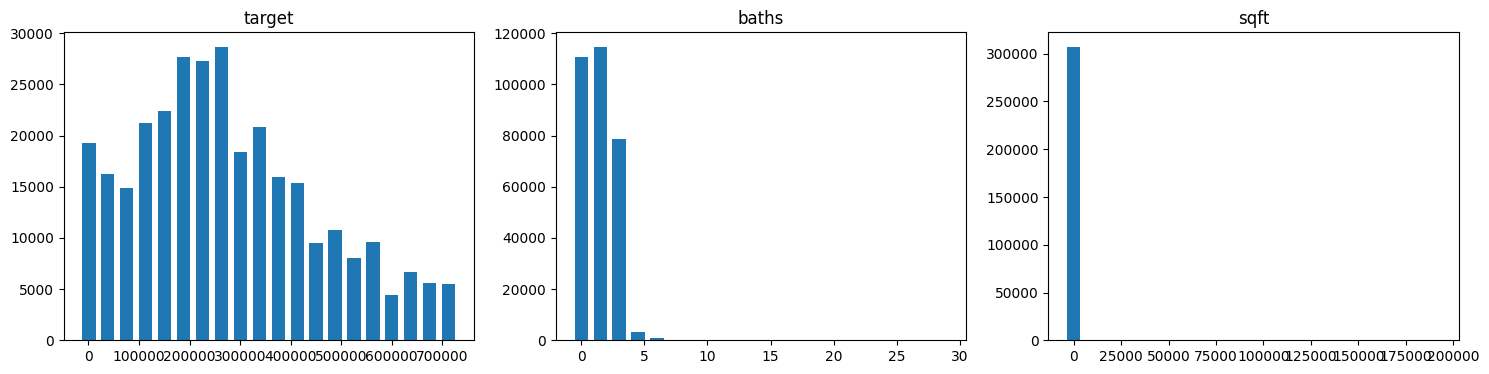

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308147 entries, 0 to 374369
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   status             308147 non-null  object 
 1   baths              308147 non-null  float64
 2   city               308147 non-null  object 
 3   sqft               308147 non-null  int64  
 4   zipcode            308147 non-null  object 
 5   state              308147 non-null  object 
 6   target             308147 non-null  int64  
 7   pool_encoded       308147 non-null  bool   
 8   Year built         308147 non-null  object 
 9   Type               308147 non-null  object 
 10  Cooling_encoded    308147 non-null  bool   
 11  Heating_encoded    308147 non-null  bool   
 12  fireplace_encoded  308147 non-null  bool   
dtypes: bool(4), float64(1), int64(2), object(6)
memory usage: 24.7+ MB


In [68]:
df = df.drop(columns=['street'], axis=1)
df = df.drop(columns=['schools'], axis=1)
df = df.drop(columns=['lotsize'], axis=1)
df = df.drop(columns=['Parking'], axis=1)
df = df.drop(columns=['Price/sqft'], axis=1)
visualize_distributions({
    'target': df['target'],
    'baths': df['baths'],
    'sqft': df['sqft']
    
})

df.info()

нужны нормализация и логарифмирование

Ранг матрицы корреляций: 3
Определитель матрицы корреляций: 0.838382


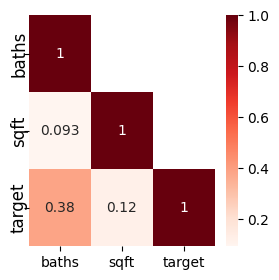

In [71]:
# Проверяем на мультиколлинеарность 
corr_matrix = np.corrcoef(df[num_features], rowvar=False)
print('Ранг матрицы корреляций:', np.linalg.matrix_rank(corr_matrix))
print('Определитель матрицы корреляций: {:.6f}'.format(np.linalg.det(corr_matrix)))
corr_matrix_tril = np.tril(corr_matrix)
corr_matrix_tril[corr_matrix_tril == 0] = np.nan
plt.figure(figsize=(len(df[num_features].columns), len(df[num_features].columns)))
sns.heatmap(corr_matrix_tril, annot=True, cmap='Reds', mask=np.isnan(corr_matrix_tril))
plt.xticks(np.arange(len(df[num_features].columns))+0.5, df[num_features].columns, rotation=0, ha='center', fontsize=10)
plt.yticks(np.arange(len(df[num_features].columns))+0.5, df[num_features].columns, ha='center', fontsize=12, va='center', rotation=90)
plt.show()

мультиколлениарность не отмечается

In [77]:
# Сохраняеи данные в CSV-файл
df.to_csv('data/data2.csv', index=False)